In [ ]:
import os

# Path to the dataset root directory
data_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/'

# All files and directories in the dataset path
print("Contents of the dataset directory:")
print(os.listdir(data_path))


Contents of the dataset directory:
['CASIA2']


In [ ]:
# Path to the CASIA2 subdirectory
casia2_path = os.path.join(data_path, 'CASIA2')

# contents of the CASIA2 directory
print("Contents of the CASIA2 directory:")
print(os.listdir(casia2_path))


Contents of the CASIA2 directory:
['CASIA 2 Groundtruth', 'Au', 'Tp']


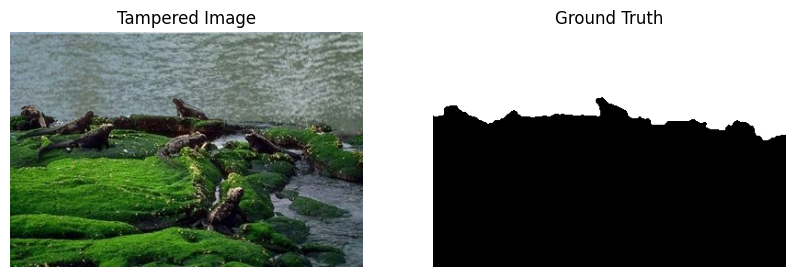

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set paths to the tampered and groundtruth folders
tampered_folder = os.path.join(data_path, 'CASIA2', 'Tp')
groundtruth_folder = os.path.join(data_path, 'CASIA2', 'CASIA 2 Groundtruth')


tampered_images = sorted([f for f in os.listdir(tampered_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))])
groundtruth_images = sorted([f for f in os.listdir(groundtruth_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))])

# Display an example of a tampered image and its corresponding ground truth
tampered_image_path = os.path.join(tampered_folder, tampered_images[0])
groundtruth_image_path = os.path.join(groundtruth_folder, groundtruth_images[0])

tampered_img = Image.open(tampered_image_path)
groundtruth_img = Image.open(groundtruth_image_path)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Tampered Image")
plt.imshow(tampered_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(groundtruth_img)
plt.axis('off')

plt.show()


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError

# Function to load and preprocess images
def load_and_preprocess_images(tampered_folder, groundtruth_folder, target_size=(224, 224)):
    tampered_images = []
    groundtruth_images = []

    # Tampered images
    for filename in os.listdir(tampered_folder):
        img_path = os.path.join(tampered_folder, filename)
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Normalize the images
            tampered_images.append(img_array)
        except UnidentifiedImageError:
            print(f"Skipping tampered image (unidentified): {img_path}")
        except Exception as e:
            print(f"Error loading tampered image {img_path}: {e}")

    # Groundtruth images
    for filename in os.listdir(groundtruth_folder):
        img_path = os.path.join(groundtruth_folder, filename)
        try:
            img = load_img(img_path, target_size=target_size, color_mode='grayscale')  # Load in grayscale for masks
            img_array = img_to_array(img) / 255.0  # Normalize the images
            groundtruth_images.append(img_array)
        except UnidentifiedImageError:
            print(f"Skipping groundtruth image (unidentified): {img_path}")
        except Exception as e:
            print(f"Error loading groundtruth image {img_path}: {e}")

    return np.array(tampered_images), np.array(groundtruth_images)

# Load the images
tampered_images, groundtruth_images = load_and_preprocess_images(tampered_folder, groundtruth_folder)

# Sizes of loaded datasets
print(f"Loaded tampered images: {tampered_images.shape}")
print(f"Loaded groundtruth images: {groundtruth_images.shape}")

# Split the dataset into training and validation sets
if tampered_images.shape[0] > 0 and groundtruth_images.shape[0] > 0:
    X_train, X_val, y_train, y_val = train_test_split(tampered_images, groundtruth_images, test_size=0.2, random_state=42)
    print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}")
else:
    print("No valid images loaded.")


Skipping tampered image (unidentified): /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/_list.txt
Skipping tampered image (unidentified): /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Thumbs.db
Loaded tampered images: (5123, 224, 224, 3)
Loaded groundtruth images: (5123, 224, 224, 1)
Training set size: (4098, 224, 224, 3), Validation set size: (1025, 224, 224, 3)


In [ ]:
from tensorflow.keras import backend as K

def mean_iou(y_true, y_pred):
    metric = tf.keras.metrics.MeanIoU(num_classes=2)  
    precisions = []

    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_thresh = tf.cast(y_pred > t, tf.int32)
        metric.reset_states()  
        metric.update_state(y_true, y_pred_thresh)
        precisions.append(metric.result())

    return tf.reduce_mean(tf.stack(precisions), axis=0)



# Loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal = alpha * K.pow(1.0 - p_t, gamma) * bce
    return K.mean(focal)

def focal_dice_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)




In [ ]:
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

smooth = 1.
dropout_rate = 0.3
act = "relu"

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-5))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-5))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

def UNetPlusPlus(img_rows=224, img_cols=224, color_type=3, num_class=1, deep_supervision=False):
    nb_filter = [32, 64, 128, 256, 512]



    
    bn_axis = -1 if K.image_data_format() == 'channels_last' else 1
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])


    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=nestnet_output_4)

    return model



In [7]:
from tensorflow.keras.layers import Dropout
import tensorflow as tf
model = UNetPlusPlus()

In [8]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,  # Use only one loss function at a time, or combine as needed
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5), dice_coef]
)


In [ ]:
hist = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,  
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20


I0000 00:00:1730393738.599523     127 service.cc:145] XLA service 0x7fa0880025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730393738.599582     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730393738.599587     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730393822.360049     127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_26', 368 bytes spill stores, 376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_7', 192 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_13', 384 bytes spill stores, 400 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_4', 192 bytes 

513/513 ━━━━━━━━━━━━━━━━━━━━ 348s 491ms/step - binary_io_u: 0.6168 - dice_coef: 0.1105 - loss: 1.3995 - val_binary_io_u: 0.7927 - val_dice_coef: 0.1294 - val_loss: 1.3837
Epoch 2/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 176s 343ms/step - binary_io_u: 0.6746 - dice_coef: 0.1016 - loss: 1.2858 - val_binary_io_u: 0.7927 - val_dice_coef: 0.1237 - val_loss: 1.3233
Epoch 3/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 175s 342ms/step - binary_io_u: 0.6682 - dice_coef: 0.1039 - loss: 1.2772 - val_binary_io_u: 0.7927 - val_dice_coef: 0.1169 - val_loss: 1.2838
Epoch 4/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 175s 341ms/step - binary_io_u: 0.6638 - dice_coef: 0.1068 - loss: 1.2670 - val_binary_io_u: 0.7927 - val_dice_coef: 0.1140 - val_loss: 1.2668
Epoch 5/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 175s 340ms/step - binary_io_u: 0.6671 - dice_coef: 0.1033 - loss: 1.2605 - val_binary_io_u: 0.7927 - val_dice_coef: 0.1070 - val_loss: 1.2467
Epoch 6/20
513/513 ━━━━━━━━━━━━━━━━━━━━ 174s 340ms/step - binary_io_u: 0.6763 - dice_coef: 0.0970 - l

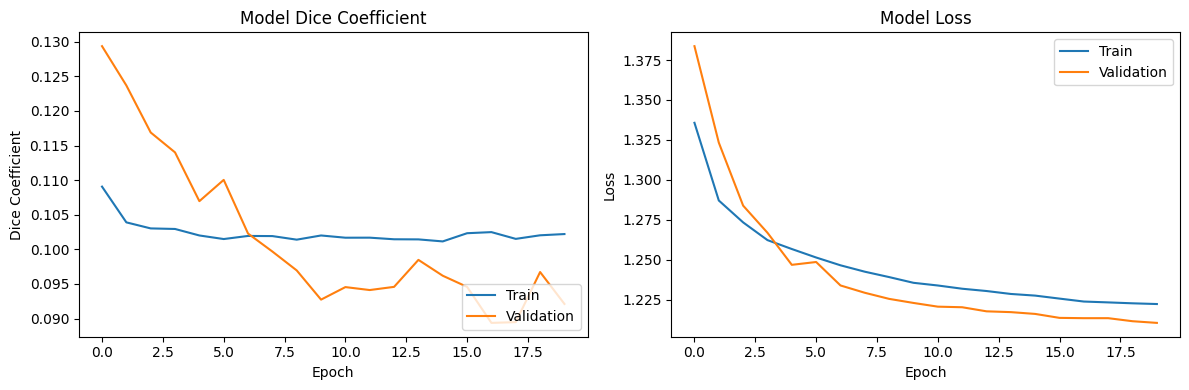

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
model.save('segment_.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


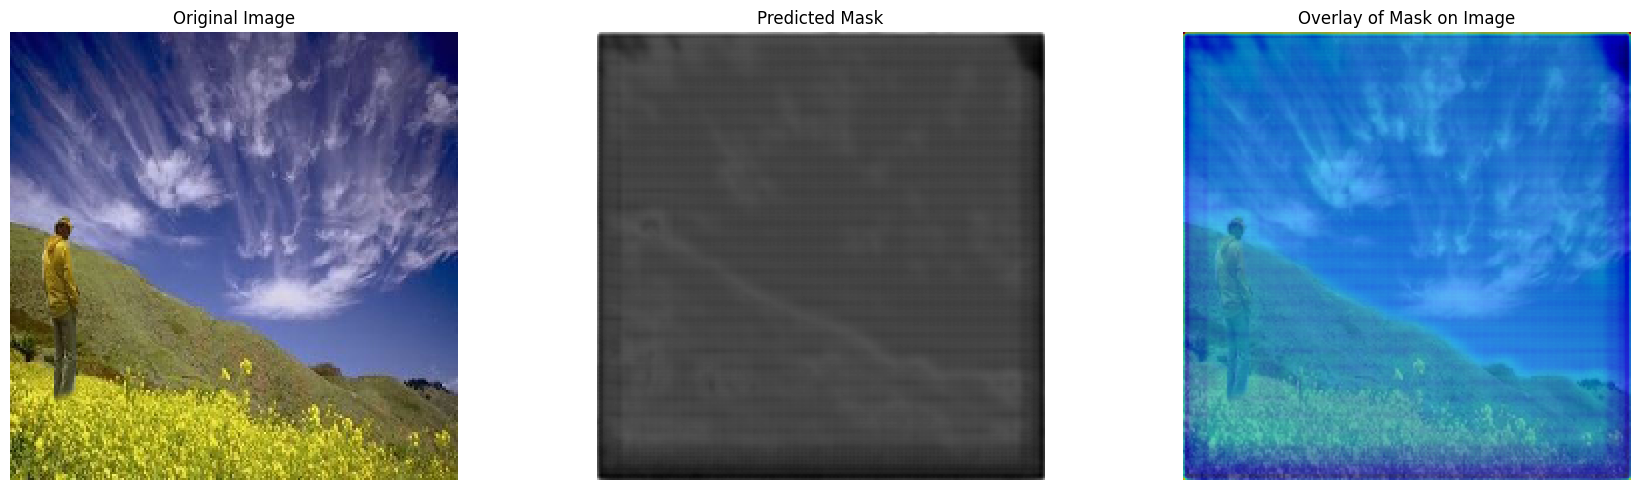

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Custom loss function and metrics
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal = alpha * K.pow(1.0 - p_t, gamma) * bce
    return K.mean(focal)

def focal_dice_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

# Image preprocessing
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Predict mask
def predict_mask(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    return predictions

# Display results with mask overlay
def display_results(img_path, predicted_mask):
    # Load and preprocess original image
    original_img = image.load_img(img_path, target_size=(224, 224))
    original_img = image.img_to_array(original_img) / 255.0
    predicted_mask = predicted_mask[0, :, :, 0]
    
    # Overlay mask on original image
    plt.figure(figsize=(18, 5))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    # Overlay mask on the original image
    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.6)  # Alpha for transparency
    plt.title('Overlay of Mask on Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model with custom objects
custom_objects = {
    'bce_dice_loss': bce_dice_loss,
    'focal_dice_loss': focal_dice_loss,
    'binary_io_u': tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5),
    'dice_coef': dice_coef,
}


try:
    model = load_model('/kaggle/working/segment_.h5', custom_objects=custom_objects)
    img_path = '/kaggle/input/segment/9.jpg'
    mask = predict_mask(model, img_path)
    display_results(img_path, mask)
except Exception as e:
    print(f"An error occurred: {str(e)}")
